In [1]:
import pandas as pd
import seaborn as sns
from itertools import chain  #for iteration
import matplotlib.pyplot as plt
from collections import Counter  #to count Gender combinations
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor  # Import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Import r2_score
from sklearn.feature_selection import SelectKBest, f_regression

#Load Data

In [2]:
loan = pd.read_csv('masked_kiva_loans.csv')
loan.head()

,id,funded_amount,loan_amount,sector,country,partner_id,term_in_months,lender_count,borrower_genders,repayment_interval,date
0,1242201,500,500,Agriculture,Pakistan,245.0,14,14,female,monthly,2/20/2017
1,1165778,325,325,Agriculture,Philippines,145.0,14,13,female,irregular,10/11/2016
2,1123052,800,800,Agriculture,Ecuador,159.0,14,29,female,bullet,7/25/2016
3,1312344,425,425,Agriculture,Philippines,136.0,8,1,female,irregular,6/2/2017
4,861422,275,275,Agriculture,Kenya,133.0,12,11,female,monthly,3/25/2015


In [3]:
loan.shape

(33561, 11)

In [4]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33561 entries, 0 to 33560
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  33561 non-null  int64  
 1   funded_amount       33561 non-null  int64  
 2   loan_amount         33561 non-null  int64  
 3   sector              33561 non-null  object 
 4   country             33561 non-null  object 
 5   partner_id          32927 non-null  float64
 6   term_in_months      33561 non-null  int64  
 7   lender_count        33561 non-null  int64  
 8   borrower_genders    33366 non-null  object 
 9   repayment_interval  33561 non-null  object 
 10  date                33561 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 2.8+ MB


In [5]:
print("Num of duplicated records:")
print(sum(loan.duplicated()))
print("---------------------")

Num of duplicated records:
0
---------------------


In [6]:
num_duplicates = loan['id'].duplicated().sum()
print("Number of duplicate IDs:", num_duplicates)

Number of duplicate IDs: 0


In [7]:
print("Num of null cells in each column:")
print(loan.isnull().sum())
print("---------------------")

Num of null cells in each column:
id                      0
funded_amount           0
loan_amount             0
sector                  0
country                 0
partner_id            634
term_in_months          0
lender_count            0
borrower_genders      195
repayment_interval      0
date                    0
dtype: int64
---------------------


In [ ]:
loan.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count
count,3.356100e+04,33561.000000,33561.000000,32927.000000,33561.000000,33561.000000
mean,9.931834e+05,789.871279,843.059653,177.819145,13.691428,20.549179
std,1.965757e+05,1177.245363,1222.188679,93.838691,8.566574,28.514324
min,6.530490e+05,0.000000,25.000000,9.000000,1.000000,0.000000
25%,8.217790e+05,250.000000,275.000000,126.000000,8.000000,7.000000
50%,9.945450e+05,450.000000,500.000000,145.000000,13.000000,13.000000
75%,1.164156e+06,900.000000,975.000000,204.000000,14.000000,24.000000
max,1.340239e+06,50000.000000,50000.000000,533.000000,145.000000,1481.000000


In [ ]:
loan.describe(include='O')

,sector,country,borrower_genders,repayment_interval,date
count,33561,33561,33366,33561,33561
unique,15,79,1032,4,1284
top,Agriculture,Philippines,female,monthly,11/18/2016
freq,9015,8096,21264,17237,74


#Preprocessing

In [8]:
loan['partner_id'].fillna(0, inplace=True)

In [9]:
loan['partner_id'] = loan['partner_id'].astype(int)

In [10]:
print("Num of null cells in each column:")
print(loan.isnull().sum())
print("---------------------")

Num of null cells in each column:
id                      0
funded_amount           0
loan_amount             0
sector                  0
country                 0
partner_id              0
term_in_months          0
lender_count            0
borrower_genders      195
repayment_interval      0
date                    0
dtype: int64
---------------------


In [12]:
loan['borrower_genders'].describe()

count      33366
unique      1032
top       female
freq       21264
Name: borrower_genders, dtype: object

In [13]:
# Count the occurrences of each combination of genders
gender_combinations = Counter(loan['borrower_genders'])

modes = gender_combinations.most_common(1)
print("Mode of gender combinations:", modes)


Mode of gender combinations: [('female', 21264)]


In [14]:
loan['borrower_genders'].fillna(loan['borrower_genders'].mode()[0], inplace=True)

In [15]:
print("Num of null cells in each column:")
print(loan.isnull().sum())
print("---------------------")

Num of null cells in each column:
id                    0
funded_amount         0
loan_amount           0
sector                0
country               0
partner_id            0
term_in_months        0
lender_count          0
borrower_genders      0
repayment_interval    0
date                  0
dtype: int64
---------------------


In [16]:
#get the counter of males and females for every loan:
def male_count(x):
    count = 0
    for gender in str(x).split(', '):
        if gender == 'male':
            count += 1
    return count

def female_count(x):
    count = 0
    for gender in str(x).split(', '):
        if gender == 'female':
            count += 1
    return count


In [17]:
loan['borrower_gender_male_count'] = loan['borrower_genders'].apply(male_count)
loan['borrower_gender_female_count'] = loan['borrower_genders'].apply(female_count)
loan = loan.drop('borrower_genders', axis=1)

In [18]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33561 entries, 0 to 33560
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            33561 non-null  int64 
 1   funded_amount                 33561 non-null  int64 
 2   loan_amount                   33561 non-null  int64 
 3   sector                        33561 non-null  object
 4   country                       33561 non-null  object
 5   partner_id                    33561 non-null  int64 
 6   term_in_months                33561 non-null  int64 
 7   lender_count                  33561 non-null  int64 
 8   repayment_interval            33561 non-null  object
 9   date                          33561 non-null  object
 10  borrower_gender_male_count    33561 non-null  int64 
 11  borrower_gender_female_count  33561 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 3.1+ MB


In [19]:
# function to check -ve values in numeric columns
def neg_val(col):
 has_negative = (loan[col] < 0).any()
 print ("Column name :" , col ," has_negative ", has_negative)

In [20]:
# put a numeric col to be checked
neg_val('lender_count')

Column name : lender_count  has_negative  False


In [21]:
loan.columns

Index(['id', 'funded_amount', 'loan_amount', 'sector', 'country', 'partner_id',
       'term_in_months', 'lender_count', 'repayment_interval', 'date',
       'borrower_gender_male_count', 'borrower_gender_female_count'],
      dtype='object')

#Visualization

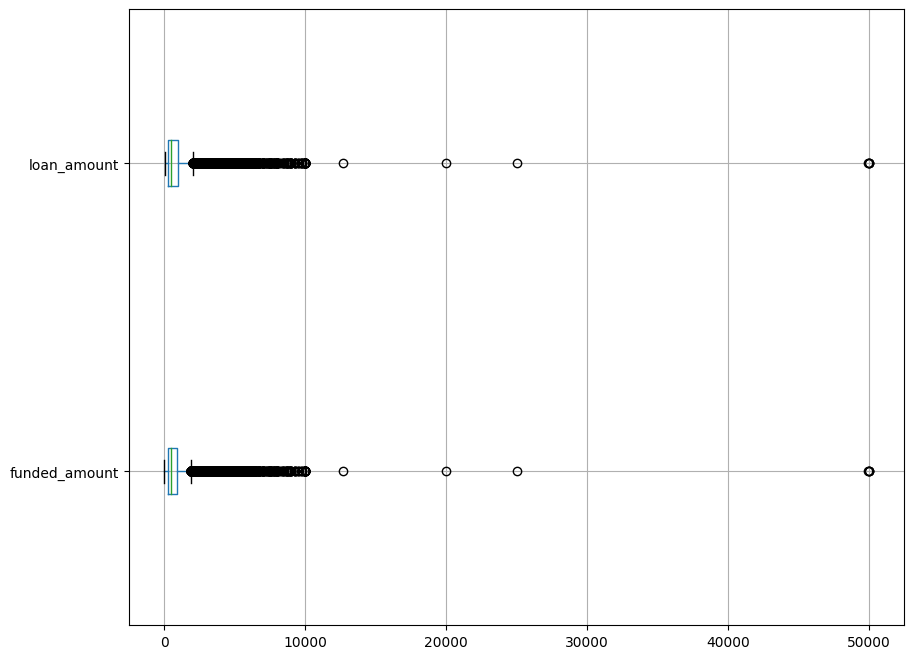

In [22]:
# Boxplots
plt.figure(figsize=(10, 8))
numerical_variables =['funded_amount', 'loan_amount']
loan[numerical_variables].boxplot(vert=False)
plt.show()

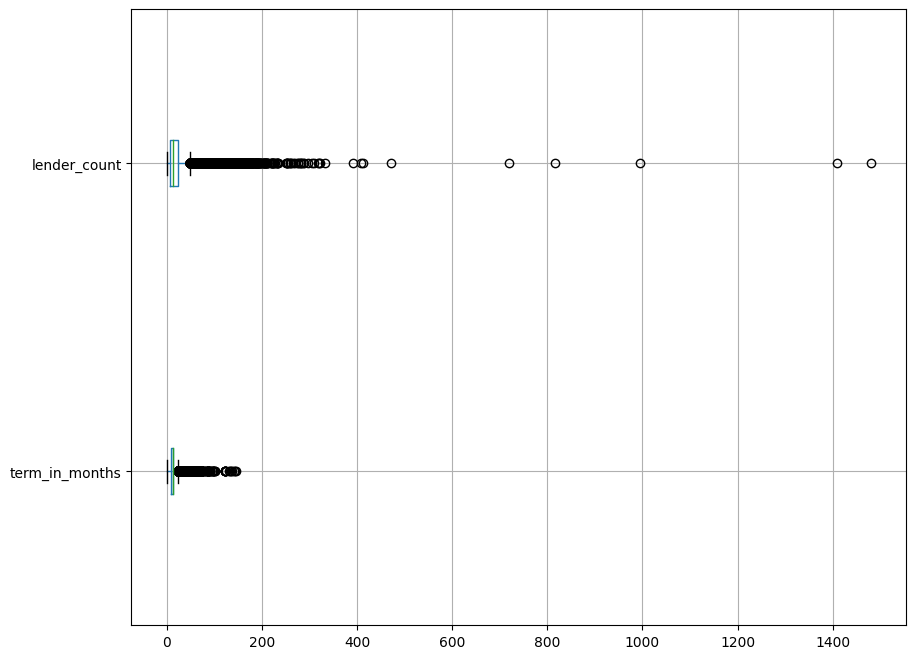

In [23]:
# Boxplots
plt.figure(figsize=(10, 8))
numerical_variables = ['term_in_months', 'lender_count']
loan[numerical_variables].boxplot(vert=False)
plt.show()

In [ ]:
#  # Select numerical columns
#  numerical_columns = ['funded_amount', 'loan_amount', 'term_in_months', 'lender_count', 'borrower_gender_male_count', 'borrower_gender_female_count']

#  X = loan[numerical_columns]

#  # Data preprocessing: scale the data
#  scaler = StandardScaler()
#  X_scaled = scaler.fit_transform(X)

#  # Apply DBSCAN clustering
#  db = DBSCAN(eps=3.0, min_samples=10).fit(X_scaled)
#  labels = db.labels_

# # # Remove outliers (data points with label -1)
#  loan_data_cleaned = loan[labels != -1]


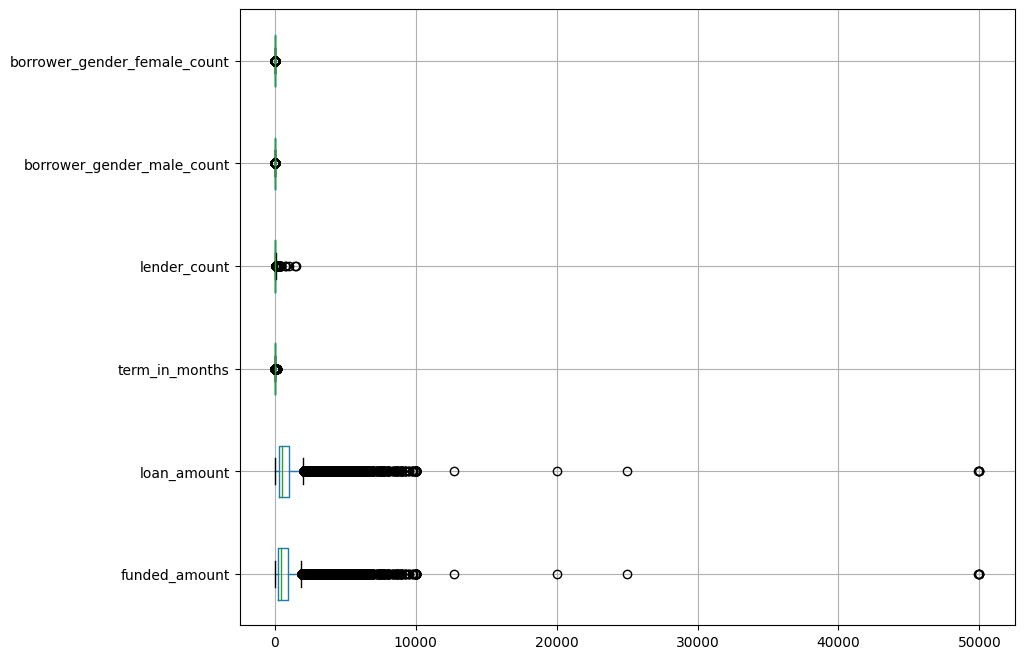

In [24]:
# Boxplots
plt.figure(figsize=(10, 8))
numerical_variables = ['funded_amount', 'loan_amount', 'term_in_months', 'lender_count', 'borrower_gender_male_count', 'borrower_gender_female_count']
loan[numerical_variables].boxplot(vert=False)
plt.show()

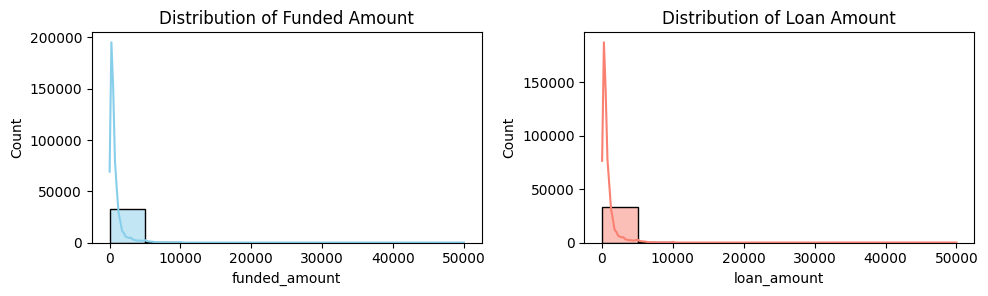

In [26]:
plt.figure(figsize=(10, 8))

#plot of Funded_amount
plt.subplot(3, 2, 1)
sns.histplot(data=loan, x='funded_amount', bins=10, kde=True, color='skyblue')
plt.title('Distribution of Funded Amount')

#plot of Loan_amount
plt.subplot(3, 2, 2)
sns.histplot(data=loan, x='loan_amount', bins=10, kde=True, color='salmon')
plt.title('Distribution of Loan Amount')

plt.tight_layout()
plt.show()


In [27]:
loan_data_cleaned = loan

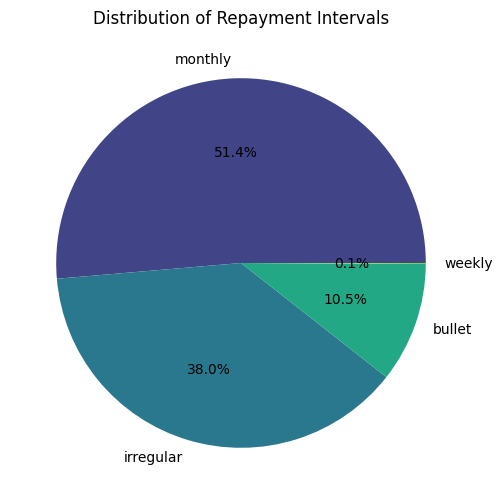

In [28]:
# pie chart for repayment_interval
plt.figure(figsize=(10, 6))
repayment_counts = loan_data_cleaned['repayment_interval'].value_counts()
plt.pie(repayment_counts, labels=repayment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(repayment_counts)))
plt.title('Distribution of Repayment Intervals')
plt.show()

In [30]:
loan_data_cleaned["sector"].unique()

array(['Agriculture', 'Arts', 'Clothing', 'Construction', 'Education',
       'Entertainment', 'Food', 'Health', 'Housing', 'Manufacturing',
       'Personal Use', 'Retail', 'Services', 'Transportation',
       'Wholesale'], dtype=object)

Text(0.5, 1.0, 'Values of the Sector')

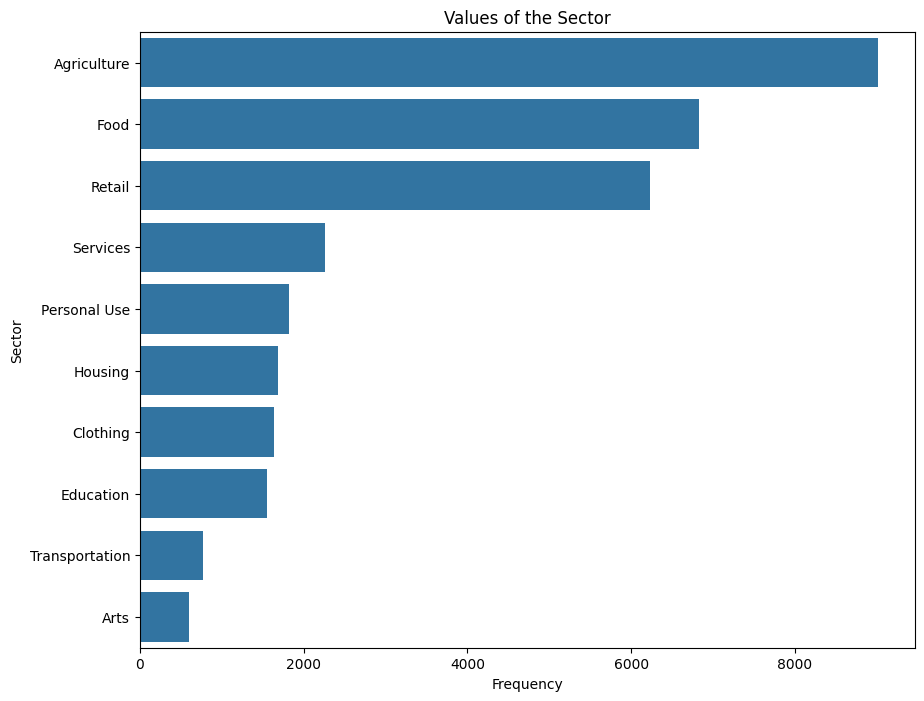

In [31]:
# Plot top 10 sectors
plt.figure(figsize = (10,8))
sns.countplot(y= 'sector', data = loan_data_cleaned[loan_data_cleaned["sector"].isin(loan_data_cleaned["sector"].value_counts()[:10].index)],
                        order=loan_data_cleaned["sector"].value_counts().iloc[:10].index)

plt.ylabel('Sector')
plt.xlabel('Frequency')
plt.title('Values of the Sector')

In [32]:
loan_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33561 entries, 0 to 33560
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            33561 non-null  int64 
 1   funded_amount                 33561 non-null  int64 
 2   loan_amount                   33561 non-null  int64 
 3   sector                        33561 non-null  object
 4   country                       33561 non-null  object
 5   partner_id                    33561 non-null  int64 
 6   term_in_months                33561 non-null  int64 
 7   lender_count                  33561 non-null  int64 
 8   repayment_interval            33561 non-null  object
 9   date                          33561 non-null  object
 10  borrower_gender_male_count    33561 non-null  int64 
 11  borrower_gender_female_count  33561 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 3.1+ MB


In [33]:
loan_data_cleaned['date'] = pd.to_datetime(loan_data_cleaned['date'])

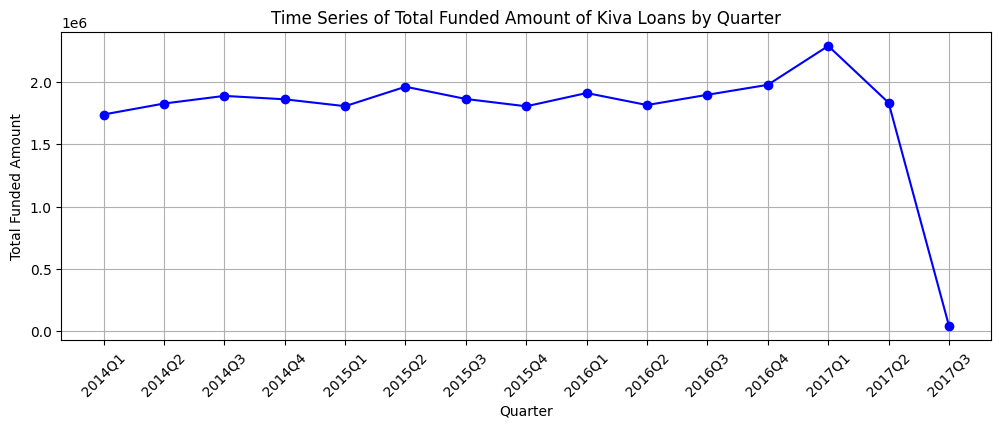

In [36]:
loan_data_cleaned['quarter'] = loan_data_cleaned['date'].dt.to_period('Q').astype(str)
# group by quarter
data_by_quarter = loan_data_cleaned.groupby('quarter')['funded_amount'].sum()
plt.figure(figsize=(12,4 ))
plt.plot(data_by_quarter.index, data_by_quarter.values, color='blue', marker='o', linestyle='-')
plt.title('Time Series of Total Funded Amount of Kiva Loans by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Total Funded Amount')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


#Encoding

In [37]:
#'sector', 'country', 'repayment_interval'
loan_data_cleaned['country'].nunique()

79

In [38]:
ohe = OneHotEncoder()
columns_to_encode = ['sector', 'country', 'repayment_interval']
loan_data_cleaned.dropna(inplace=True)

feature_array = ohe.fit_transform(loan_data_cleaned[columns_to_encode]).toarray()
feature_labels = ohe.get_feature_names_out()
features = pd.DataFrame(feature_array, columns=feature_labels)

loan_data_cleaned_encoded = pd.concat([loan_data_cleaned.reset_index(drop=True), features], axis=1)
loan_data_cleaned_encoded = loan_data_cleaned_encoded.drop(columns_to_encode, axis=1)

In [39]:
loan_data_cleaned_encoded

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count,date,borrower_gender_male_count,borrower_gender_female_count,quarter,...,country_Ukraine,country_United States,country_Vietnam,country_Yemen,country_Zambia,country_Zimbabwe,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly
0,1242201,500,500,245,14,14,2017-02-20,0,1,2017Q1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1165778,325,325,145,14,13,2016-10-11,0,1,2016Q4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1123052,800,800,159,14,29,2016-07-25,0,1,2016Q3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1312344,425,425,136,8,1,2017-06-02,0,1,2017Q2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,861422,275,275,133,12,11,2015-03-25,0,1,2015Q1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33556,886976,500,500,247,14,18,2015-05-18,0,1,2015Q2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
33557,1017003,300,300,247,12,12,2016-02-02,0,1,2016Q1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
33558,831649,225,225,421,14,9,2015-01-23,0,1,2015Q1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
33559,920920,2000,2000,80,27,54,2015-07-21,1,0,2015Q3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
loan_data_cleaned_encoded = loan_data_cleaned_encoded.drop(['quarter', 'id', 'date'], axis=1)

In [41]:
loan_data_cleaned_encoded.head()

,funded_amount,loan_amount,partner_id,term_in_months,lender_count,borrower_gender_male_count,borrower_gender_female_count,sector_Agriculture,sector_Arts,sector_Clothing,...,country_Ukraine,country_United States,country_Vietnam,country_Yemen,country_Zambia,country_Zimbabwe,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly
0,500,500,245,14,14,0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,325,325,145,14,13,0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,800,800,159,14,29,0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,425,425,136,8,1,0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,275,275,133,12,11,0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Normalization

In [ ]:
# # Not important
# scaler = MinMaxScaler()
# scaler.fit(loan_data_cleaned_encoded)
# scaled = scaler.fit_transform(loan_data_cleaned_encoded)
# scaled_df = pd.DataFrame(scaled, columns=loan_data_cleaned_encoded.columns)
# loan_data_cleaned_Normalized=scaled_df

In [42]:
correlation = loan_data_cleaned_encoded['funded_amount'].corr(loan_data_cleaned_encoded['lender_count'])
print("Correlation coefficient between funded_amount and lender_count:", correlation)

Correlation coefficient between funded_amount and lender_count: 0.8499437406735834


In [43]:
# Select top 10 features
correlation_matrix = loan_data_cleaned_encoded.corr()
target_correlation = correlation_matrix['funded_amount'].abs().sort_values(ascending=False)
top_features = target_correlation[1:11]
print(top_features)


loan_amount                                     0.961916
lender_count                                    0.849944
borrower_gender_female_count                    0.460145
country_United States                           0.242306
country_Philippines                             0.215498
borrower_gender_male_count                      0.201864
country_Paraguay                                0.201704
country_The Democratic Republic of the Congo    0.151619
term_in_months                                  0.137740
country_Bolivia                                 0.134368
Name: funded_amount, dtype: float64


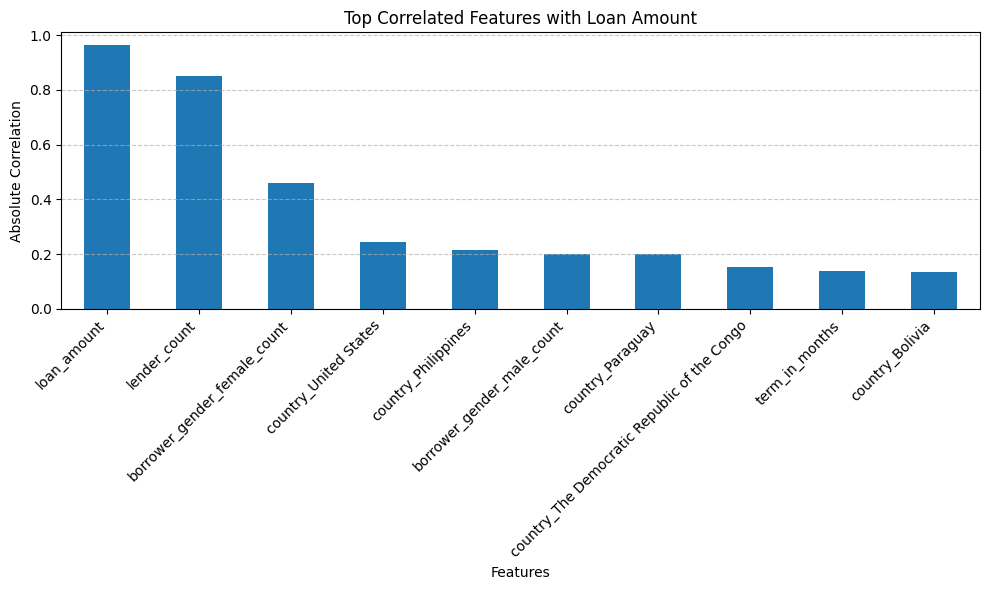

In [45]:
# Plot top_features
plt.figure(figsize=(10, 6))
top_features.plot(kind='bar', width=0.5)
plt.title('Top Correlated Features with Loan Amount')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Two linear reg  with k=10 one using corr , the other using SelectKBest and f_regression

#LR

In [46]:
# LR with Corr top_features
X = loan_data_cleaned_encoded[top_features.index]
y = loan_data_cleaned_encoded['funded_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared (R^2) value
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R^2) value: {r2}")


Mean Squared Error: 71261.8220973664
R-squared (R^2) value: 0.9374045971345208


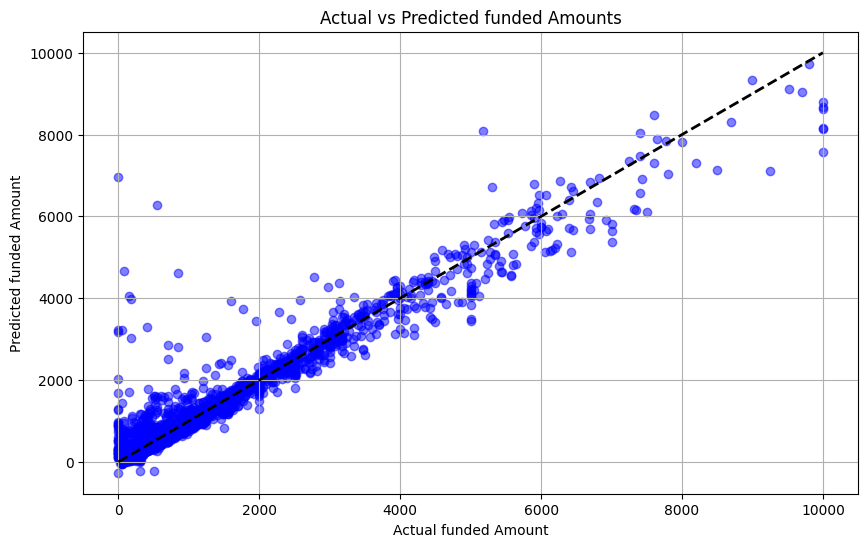

In [47]:
#for LR
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual funded Amount')
plt.ylabel('Predicted funded Amount')
plt.title('Actual vs Predicted funded Amounts')
plt.grid(True)
plt.show()

In [48]:
# LR using SelectKBest k=10
Xnew = loan_data_cleaned_encoded.drop(columns=['funded_amount'])
ynew = loan_data_cleaned_encoded['funded_amount']

selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(Xnew, ynew)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_selected, ynew, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train1, y_train1)
y_pred1 = model.predict(X_test1)

# Calculate Mean Squared Error
mse_1 = mean_squared_error(y_test1, y_pred1)
print(f"Mean Squared Error (MSE): {mse_1}")


# Calculate R-squared (R^2) value
r2_1 = r2_score(y_test1, y_pred1)
print(f"R-squared (R^2) value: {r2_1}")


Mean Squared Error (MSE): 71261.82209736643
R-squared (R^2) value: 0.9374045971345208


#DT

In [51]:
X_DTR= loan_data_cleaned_encoded.drop(columns=['funded_amount'])
y_DTR= loan_data_cleaned_encoded['funded_amount']

selector = SelectKBest(score_func=f_regression, k=10)
X_selected_DTR = selector.fit_transform(X_DTR, y_DTR)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_selected_DTR, y_DTR, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(max_depth=10)  # max depth 6 => DT=LR=> 0.937
model.fit(X_train2, y_train2)
y_pred2 = model.predict(X_test2)

# Calculate Mean Squared Error
mse_DTR = mean_squared_error(y_test2, y_pred2)
print(f"Mean Squared Error (MSE): {mse_DTR}")

# Calculate R-squared (R^2) value
r2_DTR = r2_score(y_test2, y_pred2)
print(f"R-squared (R^2) value: {r2_DTR}")


Mean Squared Error (MSE): 34485.11638084921
R-squared (R^2) value: 0.9697087488196297


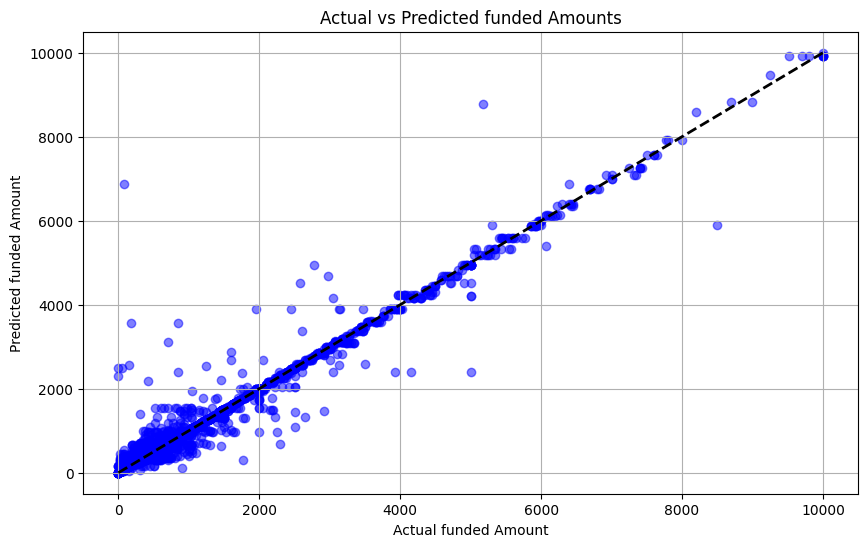

In [52]:
# for DT
plt.figure(figsize=(10, 6))
plt.scatter(y_test2, y_pred2, color='blue', alpha=0.5)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.xlabel('Actual funded Amount')
plt.ylabel('Predicted funded Amount')
plt.title('Actual vs Predicted funded Amounts')
plt.grid(True)
plt.show()